In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, Input, LSTM, RepeatVector, Reshape
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

### Matrix multiplication

In [2]:
b = 3
seq = 128
d = 512
vocab_size = 10_000
inp_mat = np.random.randn(b, d, seq)
weight_mat = np.random.randn(d, vocab_size)
# W^T * X
output_mat = weight_mat.T @ inp_mat
print(output_mat.shape) # (b, vocab_size, seq)

(3, 10000, 128)


In [3]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [4]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

print(train_data.shape, test_data.shape)

(3998, 140) (1000, 140)


In [5]:
# Normalize the data to [0, 1]

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_data

<tf.Tensor: shape=(3998, 140), dtype=float32, numpy=
array([[0.57030463, 0.46561658, 0.29058117, ..., 0.48504233, 0.4233502 ,
        0.47598344],
       [0.48320588, 0.28246963, 0.16471253, ..., 0.567567  , 0.4677294 ,
        0.2692329 ],
       [0.48144642, 0.35151404, 0.25972766, ..., 0.5479421 , 0.5077544 ,
        0.54298663],
       ...,
       [0.41039047, 0.24164985, 0.13120876, ..., 0.5277313 , 0.5654091 ,
        0.5023885 ],
       [0.5397748 , 0.4140786 , 0.28101394, ..., 0.51266515, 0.43706053,
        0.4426865 ],
       [0.29639772, 0.15988176, 0.18883787, ..., 0.53766966, 0.545786  ,
        0.40826708]], dtype=float32)>

In [6]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [7]:
normal_train_data.shape

TensorShape([2359, 140])

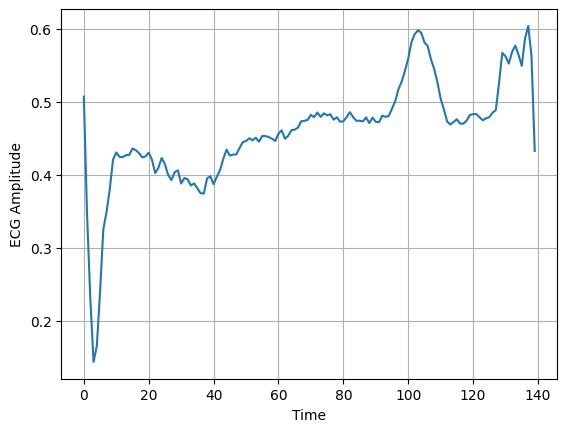

In [8]:
# Plot a normal ECG
x = np.arange(140)
y = normal_train_data[3]
plt.plot(x, y)
plt.xlabel('Time')
plt.ylabel('ECG Amplitude')
plt.grid()
plt.show()

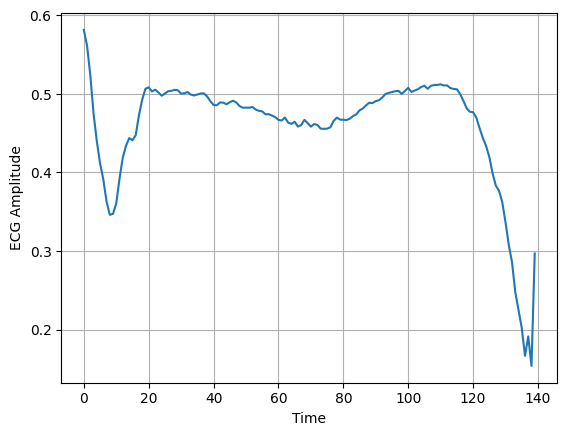

In [9]:
# Plot an anomalous ECG
x = np.arange(140)
y = anomalous_train_data[5]
plt.plot(x, y)
plt.xlabel('Time')
plt.ylabel('ECG Amplitude')
plt.grid()
plt.show()

### Dense layer
For a dense layer, if the input is `(batch_size, ..., input_dim)`, then the output will be `(batch_size, ..., units)`

In [10]:
encoder = Sequential([
    Input(shape = (140,)),
    Dense(32, activation='relu')
])

encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         4,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,512 (17.62 KB)

 Trainable params: 4,512 (17.62 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
arr = tf.cast(np.random.randn(4, 140), tf.float32)
# Make batches of 2
arr_batch = tf.data.Dataset.from_tensor_slices(arr).batch(2)

# Print one batch of arr_batch
arr_batch.as_numpy_iterator().next().shape

(2, 140)

In [12]:
# Pass one batch to encoder

encoder(arr_batch.as_numpy_iterator().next()).shape

TensorShape([2, 32])

### LSTM layer
For an LSTM layer, if the input is `(batch_size, timesteps, input_dim)`, then the output will be `(batch_size, timesteps, units)` if `return_sequences=True` and `(batch_size, units)` if `return_sequences=False`

In [10]:
enc = Sequential([
    Input(shape=(140,)),
    Reshape((140, 1)),
    LSTM(32)
])

enc.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 140, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,352 (17.00 KB)

 Trainable params: 4,352 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
arr = tf.cast(np.random.randn(4, 140), tf.float32)

arr_batch = tf.data.Dataset.from_tensor_slices(arr).batch(2)

print(arr_batch.as_numpy_iterator().next().shape)

(2, 140)


In [12]:
enc(arr_batch.as_numpy_iterator().next()).shape

TensorShape([2, 32])

In [13]:
op1 = enc(arr_batch.as_numpy_iterator().next())
op2 = RepeatVector(140)(op1)
op3 = LSTM(1, return_sequences=True)(op2)
op4 = Reshape((140,))(op3)
op2.shape, op3.shape, op4.shape

(TensorShape([2, 140, 32]), TensorShape([2, 140, 1]), TensorShape([2, 140]))

In [10]:
timesteps = 140
reshaped_dim = 1
compressed_dim_1 = 32
compressed_dim_2 = 16
compressed_dim_final = 8

In [11]:
normal_train_data.shape

TensorShape([2359, 140])

In [12]:
# New axis = 2 for normal_train_data
# normal_train_data = normal_train_data[..., tf.newaxis]
# normal_test_data = normal_test_data[..., tf.newaxis]
# anomalous_train_data = anomalous_train_data[..., tf.newaxis]
# anomalous_test_data = anomalous_test_data[..., tf.newaxis]

In [13]:
# train_data = train_data[..., tf.newaxis]
# test_data = test_data[..., tf.newaxis]
# test_data.shape

In [14]:
class AutoEncoder(Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = Sequential([
            Input(shape = (timesteps, )),
            Reshape((timesteps, reshaped_dim)),
            LSTM(compressed_dim_1, activation='relu'),
            Dense(compressed_dim_2, activation='relu'),
            Dense(compressed_dim_final, activation='relu')
        ])

        self.decoder = Sequential([
            Input(shape = (compressed_dim_final, )),
            Dense(compressed_dim_2, activation='relu'),
            Dense(compressed_dim_1, activation='relu'),
            RepeatVector(timesteps),
            LSTM(reshaped_dim, return_sequences=True, activation='relu'),
            Reshape((timesteps,))
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        # x of shape (b, timesteps, input_dim)
        return self.encoder(x)
    
    def decode(self, x):
        # x of shape (b, compressed_dim)
        return self.decoder(x)

In [15]:
temp = AutoEncoder()
x = temp.encode(tf.cast(np.random.randn(4, 140), tf.float32))
print(x.shape)
x = temp.decode(x)
print(x.shape)

(4, 8)
(4, 140)


In [16]:
autoencoder = AutoEncoder()
autoencoder.compile(optimizer='adam', loss='mae') # Mean Absolute Error |x - x_hat|
autoencoder.summary()

Model: "auto_encoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │         5,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ ?                      │           824 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,840 (22.81 KB)

 Trainable params: 5,840 (22.81 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                epochs = 100,
                batch_size = 512,
                validation_data = (test_data, test_data)
                )

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0461 - val_loss: 0.0555
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0462 - val_loss: 0.0550
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0462 - val_loss: 0.0550
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0461 - val_loss: 0.0550
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0461 - val_loss: 0.0545
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0459 - val_loss: 0.0546
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0459 - val_loss: 0.0544
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0458 - val_loss: 0.0541
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0459 - val_loss: 0.0541
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0458 - val_loss: 0.0538
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0457 - val_loss: 0.0537
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0

In [19]:
np.array(history.history['loss']).shape

(100,)

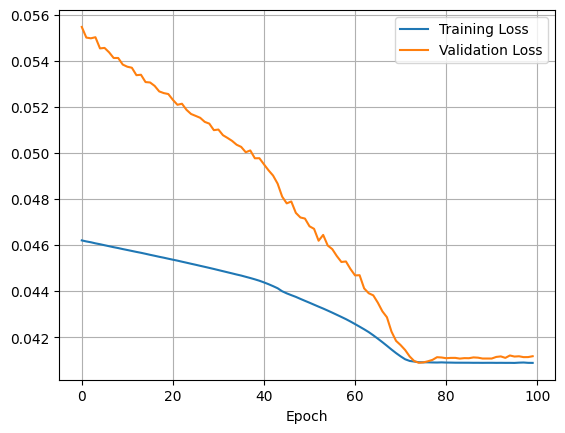

In [20]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

### Reconstruction error visualization

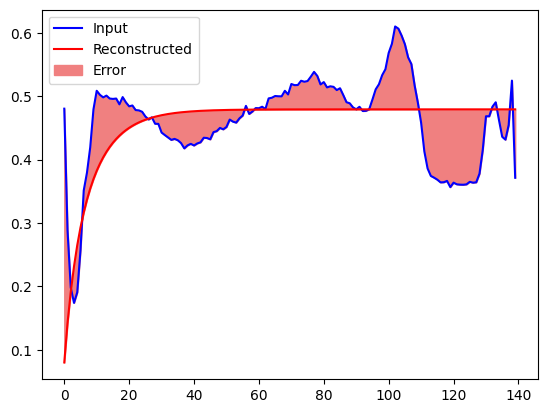

In [21]:
# For a normal test data point
encoded_data = autoencoder.encode(normal_test_data).numpy()
decoded_data = autoencoder.decode(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b', label = 'Input')
plt.plot(decoded_data[0], 'r', label = 'Reconstructed')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral',
                 label = 'Error')
plt.legend()
plt.show()

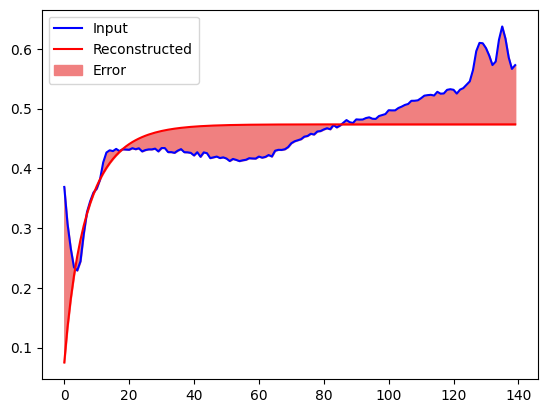

In [22]:
# For an anomalous test data point
encoded_data = autoencoder.encode(anomalous_test_data).numpy()
decoded_data = autoencoder.decode(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b', label = 'Input')
plt.plot(decoded_data[0], 'r', label = 'Reconstructed')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral',
                 label = 'Error')
plt.legend()
plt.show()

### Reconstruction error threshold

In [23]:
# Plot the reconstruction error on normal ECGs from the training set
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [24]:
train_loss.shape

TensorShape([2359])

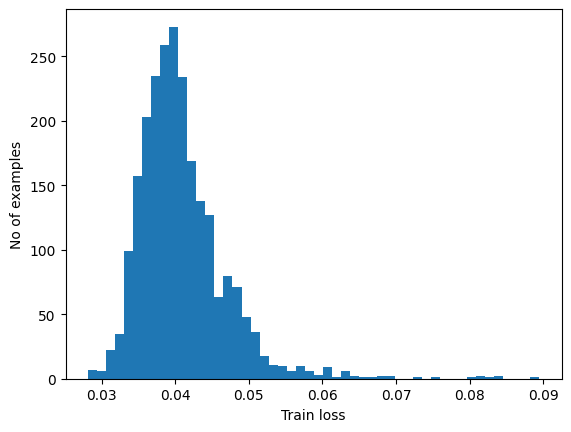

In [25]:
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [26]:
# Threshold is one standard deviation more than the mean
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.04688921


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


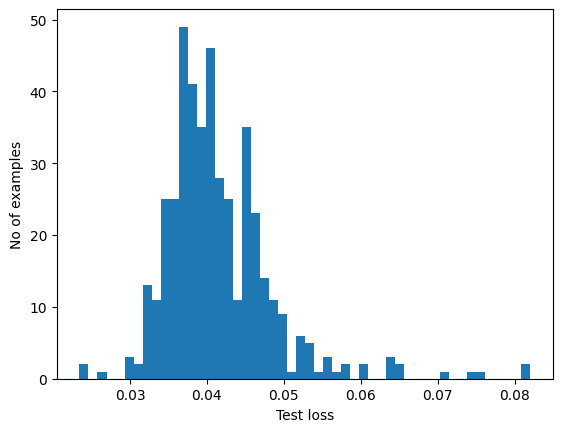

In [27]:
# Test loss
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [28]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print(f"Accuracy score: {accuracy_score(labels, predictions)}")
    print(f"Precision score: {precision_score(labels, predictions)}")
    print(f"Recall score: {recall_score(labels, predictions)}")

In [29]:
predictions = predict(autoencoder, test_data, threshold)
print_stats(predictions, test_labels)

Accuracy score: 0.554
Precision score: 0.5658198614318707
Recall score: 0.875
